使用机器学习模型进行交易
本教程将展示如何使用backtesting.py框架训练和回溯测试机器学习价格预测模型。假设您已经熟悉基本的框架用法和一般的机器学习。
在本教程中，我们将使用近一年的每小时欧元/美元外汇数据样本

In [89]:
from backtesting.test import EURUSD, SMA

data = EURUSD.copy().iloc[:,:-1]

print(data.info, data.info())


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5000 entries, 2017-04-19 09:00:00 to 2018-02-07 15:00:00
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    5000 non-null   float64
 1   High    5000 non-null   float64
 2   Low     5000 non-null   float64
 3   Close   5000 non-null   float64
dtypes: float64(4)
memory usage: 195.3 KB
<bound method DataFrame.info of                         Open     High      Low    Close
2017-04-19 09:00:00  1.07160  1.07220  1.07083  1.07219
2017-04-19 10:00:00  1.07214  1.07296  1.07214  1.07260
2017-04-19 11:00:00  1.07256  1.07299  1.07170  1.07192
2017-04-19 12:00:00  1.07195  1.07280  1.07195  1.07202
2017-04-19 13:00:00  1.07200  1.07230  1.07045  1.07050
...                      ...      ...      ...      ...
2018-02-07 11:00:00  1.23390  1.23548  1.23386  1.23501
2018-02-07 12:00:00  1.23501  1.23508  1.23342  1.23422
2018-02-07 13:00:00  1.23422  1.23459  1.23338  1.23372
20

在监督式机器学习中，我们尝试学习一个将输入特征向量（自变量）映射到已知输出值（因变量）的函数：

$$ f\colon X \to \mathbf{y} $$

这样，只要我们的模型函数足够，我们就可以从新获取的输入特征向量中预测未来的输出值，从而达到一定程度的确定性。在我们的示例中，我们将尝试在未来两天内将几个价格派生的特征和常见的技术指标映射到价格点。我们构建模型设计矩阵$X$下面:

In [90]:
data['X_Open'] = data.Open
data['X_High'] = data.High
data['X_Low'] = data.Low
data['X_Close'] = data.Close
data = data.dropna().astype(float)
print(data.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5000 entries, 2017-04-19 09:00:00 to 2018-02-07 15:00:00
Data columns (total 8 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Open     5000 non-null   float64
 1   High     5000 non-null   float64
 2   Low      5000 non-null   float64
 3   Close    5000 non-null   float64
 4   X_Open   5000 non-null   float64
 5   X_High   5000 non-null   float64
 6   X_Low    5000 non-null   float64
 7   X_Close  5000 non-null   float64
dtypes: float64(8)
memory usage: 351.6 KB
None


Classification accuracy:  0.5506430868167203
(4976, 4) 2 (4976,) 1


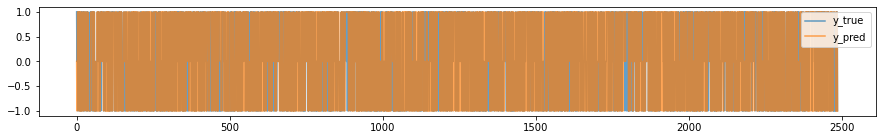

In [94]:
import numpy as np


def get_X(data):
    """返回模型设计矩阵 X"""
    X = data.filter(like='X').values
    # print(X.shape, X.ndim)
    return X


def get_y(data):
    """返回因变量 y
    # 收盘价>开盘价 标记类别为1 收盘价<开盘价 标记类别为-1 收盘价=开盘价 标记类别为0
    """
    epsilon = 0.001  #误差
    y = data.Close.pct_change(24).shift(-24)  # 大约一天后返回
    y[y.between(-epsilon, epsilon)] = 0             # 货币贬值的回报率低于epsilon
    y[y > 0] = 1
    y[y < 0] = -1
    # print(y.shape, y.ndim)
    return y


def get_clean_Xy(df):
    """返回(X, y)已清除的NaN值"""
    X = get_X(df)
    y = get_y(df).values
    isnan = np.isnan(y)
    X = X[~isnan]
    y = y[~isnan]
    # print(X.shape, X.ndim, y.shape, y.ndim)
    return X, y
'''
让我们看看我们的数据如何使用来自最先进的scikit-learn Python机器学习包的简单k-最近邻（kNN）算法进行建模。 Let’s see how our data performs modeled using a simple k-nearest neighbors (kNN) algorithm from the state of the art scikit-learn Python machine learning package. To avoid (or at least demonstrate) overfitting, 为了避免（或至少演示）过拟合，总是将数据拆分为训练集和测试集;特别是，不要在构建模型的相同数据上验证模型性能。
'''
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

X, y = get_clean_Xy(data)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.5, random_state=0)

clf = KNeighborsClassifier(7)  # Model the output based on 7 "nearest" examples
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

_ = pd.DataFrame({'y_true': y_test, 'y_pred': y_pred}).plot(figsize=(15, 2), alpha=.7)
print('Classification accuracy: ', np.mean(y_test == y_pred))
print(X.shape, X.ndim, y.shape, y.ndim)

In [93]:
%%time

from backtesting import Backtest, Strategy

N_TRAIN = 400


class MLTrainOnceStrategy(Strategy):
    price_delta = .004  # 0.4%

    def init(self):
        # 初始化我们的模型，一个kNN分类器
        self.clf = KNeighborsClassifier(7)

        # 在第一个N_TRAIN示例上提前训练分类器
        df = self.data.df.iloc[:N_TRAIN]
        X, y = get_clean_Xy(df)
        self.clf.fit(X, y)

        # Plot y 检验
        self.I(get_y, self.data.df, name='y_true')

        # 预备好 empty, all-NaN 预报指标
        self.forecasts = self.I(lambda: np.repeat(np.nan, len(self.data)), name='forecast')

    def next(self):
        # 跳过训练、样本内数据
        if len(self.data) < N_TRAIN:
            return

        # 只处理样本外的数据。准备一些变量
        high, low, close = self.data.High, self.data.Low, self.data.Close
        current_time = self.data.index[-1]

        # self.data.df.filter()
        # 预测下一个动作
        X = get_X(self.data.df.iloc[-1:])
        forecast = self.clf.predict(X)[0]

        # 更新标绘的“预测”指标
        self.forecasts[-1] = forecast

        # 如果我们的预测是向上的，而我们并没有持有多头头寸，那么就买入10%的可用账户权益的多头订单。反之亦然。
        # 同时设定目标获利和止损价格为当前收盘价的一个delta值。
        upper, lower = close[-1] * (1 + np.r_[1, -1]*self.price_delta)

        if forecast == 1 and not self.position.is_long:
            self.buy(size=.1, tp=upper, sl=lower)
        elif forecast == -1 and not self.position.is_short:
            self.sell(size=.1, tp=lower, sl=upper)

        # 此外，对已经开仓超过两天的交易设置积极的止损
        for trade in self.trades:
            if current_time - trade.entry_time > pd.Timedelta('2 days'):
                if trade.is_long:
                    trade.sl = max(trade.sl, low)
                else:
                    trade.sl = min(trade.sl, high)


bt = Backtest(data, MLTrainOnceStrategy, commission=.0002, margin=.05)
bt.run()

(400, 4) 2
(400,) 1
(376, 4) 2 (376,) 1
(5000,) 1
(1, 4) 2
(1, 4) 2
(1, 4) 2
(1, 4) 2
(1, 4) 2
(1, 4) 2
(1, 4) 2
(1, 4) 2
(1, 4) 2
(1, 4) 2
(1, 4) 2
(1, 4) 2
(1, 4) 2
(1, 4) 2
(1, 4) 2
(1, 4) 2
(1, 4) 2
(1, 4) 2
(1, 4) 2
(1, 4) 2
(1, 4) 2
(1, 4) 2
(1, 4) 2
(1, 4) 2
(1, 4) 2
(1, 4) 2
(1, 4) 2
(1, 4) 2
(1, 4) 2
(1, 4) 2
(1, 4) 2
(1, 4) 2
(1, 4) 2
(1, 4) 2
(1, 4) 2
(1, 4) 2
(1, 4) 2
(1, 4) 2
(1, 4) 2
(1, 4) 2
(1, 4) 2
(1, 4) 2
(1, 4) 2
(1, 4) 2
(1, 4) 2
(1, 4) 2
(1, 4) 2
(1, 4) 2
(1, 4) 2
(1, 4) 2
(1, 4) 2
(1, 4) 2
(1, 4) 2
(1, 4) 2
(1, 4) 2
(1, 4) 2
(1, 4) 2
(1, 4) 2
(1, 4) 2
(1, 4) 2
(1, 4) 2
(1, 4) 2
(1, 4) 2
(1, 4) 2
(1, 4) 2
(1, 4) 2
(1, 4) 2
(1, 4) 2
(1, 4) 2
(1, 4) 2
(1, 4) 2
(1, 4) 2
(1, 4) 2
(1, 4) 2
(1, 4) 2
(1, 4) 2
(1, 4) 2
(1, 4) 2
(1, 4) 2
(1, 4) 2
(1, 4) 2
(1, 4) 2
(1, 4) 2
(1, 4) 2
(1, 4) 2
(1, 4) 2
(1, 4) 2
(1, 4) 2
(1, 4) 2
(1, 4) 2
(1, 4) 2
(1, 4) 2
(1, 4) 2
(1, 4) 2
(1, 4) 2
(1, 4) 2
(1, 4) 2
(1, 4) 2
(1, 4) 2
(1, 4) 2
(1, 4) 2
(1, 4) 2
(1, 4) 2
(1, 4) 2
(1, 4) 2
(1, 4

Start                     2017-04-19 09:00:00
End                       2018-02-07 15:00:00
Duration                    294 days 06:00:00
Exposure Time [%]                        92.0
Equity Final [$]                  7119.045323
Equity Peak [$]                  10075.428965
Return [%]                         -28.809547
Buy & Hold Return [%]               14.628937
Return (Ann.) [%]                  -28.905861
Volatility (Ann.) [%]                8.673599
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                  -31.032903
Avg. Drawdown [%]                   -10.44909
Max. Drawdown Duration      271 days 03:00:00
Avg. Drawdown Duration       90 days 12:00:00
# Trades                                  264
Win Rate [%]                        42.045455
Best Trade [%]                       0.389272
Worst Trade [%]                     -0.447261
Avg. Trade [%]                    